# 截取模型中5个层的信息进行tsne降维可视化分析
第一层：x_eGeMAPS_transformed = self.eGeMAPS_transform(x_eGeMAPS_weighted)  
第二层：x_VGGish = self.VGGish_transform(x_VGGish)  
第三层：x_eGeMAPS_transformed = self.eGeMAPS_net(x_eGeMAPS_transformed)  
第四层：x_VGGish_transformed = self.VGGish_net(x_VGGish)  
第五层：x = self.fusion(x_eGeMAPS_transformed, x_VGGish_transformed)  

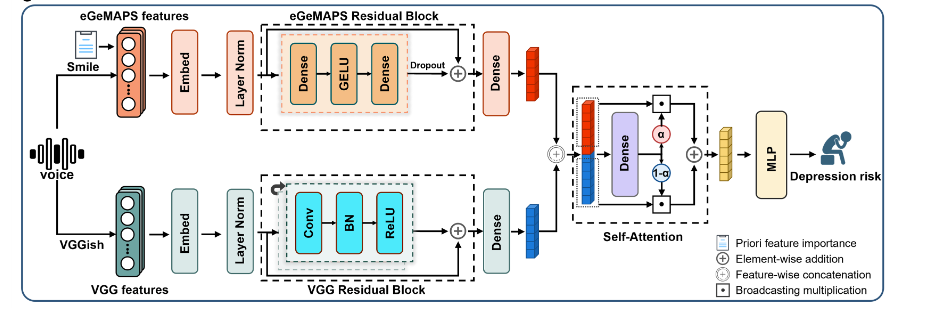

In [1]:
import torch
import torch.nn as nn
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
import os
import joblib
from torchvggish import vggish, vggish_input
from joblib import Parallel, delayed, dump
from sklearn.preprocessing import StandardScaler
from tools.evaluate import evaluate_model, plot_roc_curve, overall_evaluate_plot, calculate_mean_std_metrics
from tools.common import setup_seed,init_logger
from tools.utils import get_eGe_matrix,get_vggish_features,get_best_para_from_optuna
from tools.model import CFRAFN
import matplotlib.pyplot as plt
import optuna
from sklearn.metrics import confusion_matrix
import seaborn as sns
import swanlab
from swanlab.plugin.notification import WXWorkCallback
import random
from collections import defaultdict
import torch.nn.functional as F
from sklearn.manifold import TSNE

# 1.读取数据

In [2]:
setup_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

df = pd.read_csv("../data/group_control.csv")
shuffled_df = df.sample(frac=1, random_state=42).reset_index(drop=True)
LOGFILE = f"../result/02optuna/depression_model_performance622.log"
logger,file_handler = init_logger(LOGFILE)

X = shuffled_df['name']
y = shuffled_df['class']
self_folder = "../data/group_control/"


def read_data(save_path):

    X_train_eGe_list_path = os.path.join(save_path,"X_train_eGe_list.joblib")
    X_test_eGe_list_path = os.path.join(save_path,"X_test_eGe_list.joblib")
    X_train_VGGish_list_path = os.path.join(save_path,"X_train_VGGish_list.joblib")
    X_test_VGGish_list_path = os.path.join(save_path,"X_test_VGGish_list.joblib")
    y_train_list_path = os.path.join(save_path,"y_train_list.joblib")
    y_test_list_path = os.path.join(save_path,"y_test_list.joblib")

    X_train_eGe_list = joblib.load(X_train_eGe_list_path)
    X_test_eGe_list = joblib.load(X_test_eGe_list_path)
    X_train_VGGish_list = joblib.load(X_train_VGGish_list_path) 
    X_test_VGGish_list = joblib.load(X_test_VGGish_list_path)
    y_train_list = joblib.load(y_train_list_path)
    y_test_list = joblib.load(y_test_list_path)

    return X_train_eGe_list,X_test_eGe_list,X_train_VGGish_list,X_test_VGGish_list,y_train_list,y_test_list

with open("../result/01preprocess/eGe_feature_cumul0.99.txt",'r')as f:
    eGe_feature = [line.strip() for line in f]

feature_weights = pd.read_csv('../result/01preprocess/03sorted_feature_importance.csv',index_col=0)
feature_weights = feature_weights.squeeze()
feature_weights = feature_weights[eGe_feature]

labels = shuffled_df['class']
classes = np.unique(labels)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=labels)
print(labels.sum())
# class_weights = torch.tensor(class_weights, dtype=torch.float, device=device)
class_weights = torch.tensor(np.array([100,1]), dtype=torch.float, device=device)

220


# 2.指定目标层，提取目标层特征